# Autoencoders

# 2 types of autoencoders to try

important note cant run the code sequentially since x_train and x_val x_test change throughout the code so need to run the split cell and the scale cell before running any autoencode w/o smote and for the one with smote run the splitting cell then the code that section bec we scale after applying smote sorry if its a bit complicated..
1. Vanilla (one layer) autoencoders 
2. Multilayer autoencoder

**all with softmax to classify
without smote just standardised the dataset using StandardScaler fitting it only on the training data to prevent data leakage and then applying the same transformation to the validation and test set

SMOTE gave a slightly better result 52% (f-score)
**The code with smote repeats the same preprocessing technique as before with the scaling^^ so to run that section you would need to run the import libraries then the cell below it then the code in the smote section no need to runn all cells since it will scale again 

## Import the libraries

In [51]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler

## Load the data

We don't need the labels as the autoencoders are unsupervised network

## Preprocess (need to rerun this cell and the one below it for each autoencoder since x_train changes throughout code)

# splitting cell 

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = r'C:\Users\l_alm\resnet1d-master\content\customerTargeting.csv'
df = pd.read_csv(data)
X = df.drop(columns=["target"])
y=df["target"]

# 80% (train + validation) and 20% (test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 60% (train) and 20% (validation) from the 80% data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


#the final sizes
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")




Train: 3972, Validation: 1324, Test: 1324


# scaling cell

# If you're going to run SMOTE section please dont run this cell below

In [36]:
scaler = StandardScaler()
scaler.fit(X_train)  # Fit only on training data

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)  # Apply same transformation
X_test = scaler.transform(X_test)  # Apply same transformation


# **Vanilla Autoencoder**

### Create the network

The first network is the most simple autoencoder. It has three layers Input - encoder - decoder

In [5]:
input_size = 70
hidden_size = 1000
bottleneck_size = 1000
output_size = 70

In [6]:


input_layer = Input(shape=(input_size,))

encoder = Dense(hidden_size, activation="relu")(input_layer)


bottleneck = Dense(bottleneck_size, activation="relu")(encoder) 


decoder = Dense(hidden_size, activation="relu")(bottleneck)

output_layer = Dense(input_size, activation="sigmoid")(decoder)  

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse') 

### Train

In [7]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder.fit(X_train, X_train, epochs=200, batch_size=128, validation_data=(X_val, X_val), shuffle=True, callbacks=[early_stopping])

Epoch 1/200
32/32 [==============================] - 1s 26ms/step - loss: 0.7566 - val_loss: 0.6660
Epoch 2/200
32/32 [==============================] - 1s 20ms/step - loss: 0.6410 - val_loss: 0.6121
Epoch 3/200
32/32 [==============================] - 1s 22ms/step - loss: 0.5996 - val_loss: 0.5909
Epoch 4/200
32/32 [==============================] - 1s 23ms/step - loss: 0.5849 - val_loss: 0.5842
Epoch 5/200
32/32 [==============================] - 1s 21ms/step - loss: 0.5806 - val_loss: 0.5770
Epoch 6/200
32/32 [==============================] - 1s 23ms/step - loss: 0.5757 - val_loss: 0.5707
Epoch 7/200
32/32 [==============================] - 1s 20ms/step - loss: 0.5673 - val_loss: 0.5666
Epoch 8/200
32/32 [==============================] - 1s 22ms/step - loss: 0.5655 - val_loss: 0.5679
Epoch 9/200
32/32 [==============================] - 1s 22ms/step - loss: 0.5655 - val_loss: 0.5633
Epoch 10/200
32/32 [==============================] - 1s 26ms/step - loss: 0.5635 - val_loss: 0.5628

### Predict on the test set

In [8]:
decoded = autoencoder.predict(X_test)

42/42 [==============================] - 0s 6ms/step


### Plot

### Plot the losses

dict_keys(['loss', 'val_loss'])


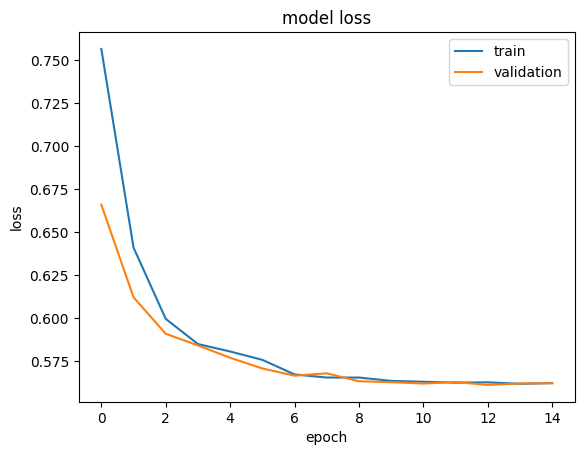

In [9]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [10]:
from keras.models import Model

#extracting encoder part from trained autoencoder
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=2).output)  #bottleneck layer


In [11]:
X_train_encoded = encoder_model.predict(X_train)
X_val_encoded = encoder_model.predict(X_val)
X_test_encoded = encoder_model.predict(X_test)

42/42 [==============================] - 0s 4ms/step


In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

#defining a classifier using the encoded features
classifier = Sequential([
    Dense(3, activation="softmax" ) #output layer (3 classes)
     ])

# Compile the classifier
classifier.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy')


In [16]:



#compute class weights
#class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
#class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))} improves performance in classes 0 and 2 but lowers the performance
#print("class Weights:", class_weights_dict)
# Train classifier
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 
history=classifier.fit(X_train_encoded, y_train, epochs=200, batch_size=128, validation_data=(X_val_encoded, y_val), shuffle=True, callbacks=[early_stopping], )



Epoch 1/200
32/32 [==============================] - 1s 7ms/step - loss: 1.0697 - val_loss: 0.9856
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9528 - val_loss: 0.9786
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9360 - val_loss: 0.9724
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9373 - val_loss: 0.9601
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9275 - val_loss: 0.9997
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9464 - val_loss: 0.9686
Epoch 7/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9393 - val_loss: 0.9802
Epoch 8/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9268 - val_loss: 0.9487
Epoch 9/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9275 - val_loss: 0.9506
Epoch 10/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9344 - val_loss: 0.9777
Epoch 11/

dict_keys(['loss', 'val_loss'])


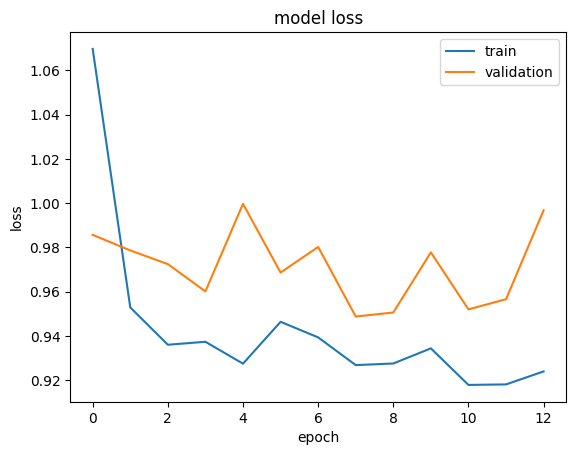

In [17]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [18]:
from sklearn.metrics import classification_report


y_pred_prob = classifier.predict(X_test_encoded)

#converting to class labels
y_pred = y_pred_prob.argmax(axis=1)  #getting class with highest probability

print(classification_report(y_test, y_pred, digits=4))


42/42 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.3056    0.1006    0.1514       328
           1     0.5883    0.8493    0.6951       604
           2     0.6047    0.5306    0.5652       392

    accuracy                         0.5695      1324
   macro avg     0.4995    0.4935    0.4706      1324
weighted avg     0.5231    0.5695    0.5220      1324



---

# **Multilayer autoencoder**

trying 2 layers 

In [24]:
input_size = 70
hidden_size1= 1000
hidden_size2= 1000
bottleneck_size= 1000
output_size = 70

input_layer = Input(shape=(input_size,))
encoder = Dense(hidden_size1, activation="relu")(input_layer)
encoder = Dense(hidden_size2, activation="relu")(encoder)
bottleneck = Dense(bottleneck_size, activation="relu")(encoder)  


decoder = Dense(hidden_size2, activation="relu")(bottleneck)
decoder = Dense(hidden_size1, activation="relu")(decoder)
output_layer = Dense(output_size, activation="sigmoid")(decoder) 

autoencoder2 = Model(inputs=input_layer, outputs=output_layer)
autoencoder2.compile(optimizer='adam', loss='mse')

### Train the network

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder2.fit(X_train, X_train, batch_size=128, epochs=200, verbose=1, validation_data=(X_val, X_val), shuffle=True,callbacks=[early_stopping])

Epoch 1/200
32/32 [==============================] - 3s 59ms/step - loss: 0.7989 - val_loss: 0.7151
Epoch 2/200
32/32 [==============================] - 2s 55ms/step - loss: 0.6952 - val_loss: 0.6862
Epoch 3/200
32/32 [==============================] - 2s 56ms/step - loss: 0.6659 - val_loss: 0.6517
Epoch 4/200
32/32 [==============================] - 2s 52ms/step - loss: 0.6401 - val_loss: 0.6321
Epoch 5/200
32/32 [==============================] - 2s 55ms/step - loss: 0.6186 - val_loss: 0.6134
Epoch 6/200
32/32 [==============================] - 2s 54ms/step - loss: 0.6037 - val_loss: 0.6046
Epoch 7/200
32/32 [==============================] - 2s 54ms/step - loss: 0.5956 - val_loss: 0.6041
Epoch 8/200
32/32 [==============================] - 2s 54ms/step - loss: 0.5925 - val_loss: 0.5906
Epoch 9/200
32/32 [==============================] - 2s 54ms/step - loss: 0.5859 - val_loss: 0.5891
Epoch 10/200
32/32 [==============================] - 2s 59ms/step - loss: 0.5833 - val_loss: 0.5835

### Predict on the test set

In [26]:
decoded_output= autoencoder2.predict(X_test)

42/42 [==============================] - 0s 8ms/step


### Plot the losses

dict_keys(['loss', 'val_loss'])


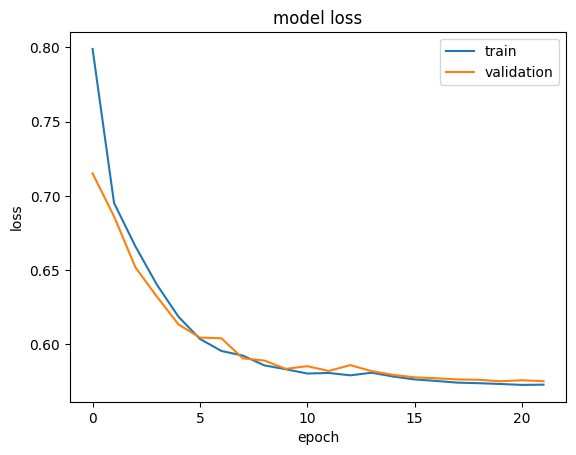

In [27]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [28]:
encoder_model = Model(inputs=autoencoder2.input, outputs=autoencoder2.get_layer(index=3).output)  #bottleneck layer

In [29]:
X_train_encoded = encoder_model.predict(X_train)
X_val_encoded = encoder_model.predict(X_val)
X_test_encoded = encoder_model.predict(X_test)

42/42 [==============================] - 0s 6ms/step


In [30]:
#defining a classifier using the encoded features
classifier = Sequential([
    Dense(3, activation="softmax")  #output layer (3 classes)
])

# Compile the classifier
classifier.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy')


In [31]:

#compute class weights
#class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
#class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))} improves performance in classes 0 and 2 but lowers the performance
#print("class Weights:", class_weights_dict)
# Train classifier
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) 
history=classifier.fit(X_train_encoded, y_train, epochs=200, batch_size=128, validation_data=(X_val_encoded, y_val), shuffle = True,callbacks=[early_stopping])



Epoch 1/200
32/32 [==============================] - 0s 6ms/step - loss: 1.0957 - val_loss: 0.9963
Epoch 2/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9472 - val_loss: 0.9690
Epoch 3/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9336 - val_loss: 0.9760
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.9237 - val_loss: 0.9654
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9171 - val_loss: 0.9680
Epoch 6/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9178 - val_loss: 0.9837


# plot

dict_keys(['loss', 'val_loss'])


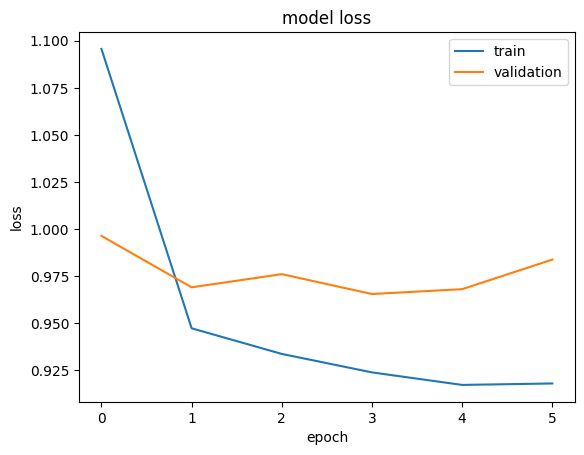

In [32]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [33]:
from sklearn.metrics import classification_report


y_pred_prob = classifier.predict(X_test_encoded)

#converting to class labels
y_pred = y_pred_prob.argmax(axis=1)  #getting class with highest probability

print(classification_report(y_test, y_pred, digits=4))

42/42 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.2737    0.1494    0.1933       328
           1     0.5987    0.7632    0.6710       604
           2     0.5600    0.5357    0.5476       392

    accuracy                         0.5438      1324
   macro avg     0.4775    0.4828    0.4706      1324
weighted avg     0.5067    0.5438    0.5161      1324



# Trying 3 layers

In [37]:

input_size = 70
hidden_size1 = 1000
hidden_size2 = 1000
hidden_size3 = 1000
bottleneck_size = 1000
output_size = 70

input_layer = Input(shape=(input_size,))


encoder = Dense(hidden_size1, activation="relu")(input_layer)
encoder = Dense(hidden_size2, activation="relu")(encoder)
encoder = Dense(hidden_size3, activation="relu")(encoder)
bottleneck = Dense(bottleneck_size, activation="relu")(encoder)  # Bottleneck layer

#decoder with 3 hidden layers
decoder = Dense(hidden_size3, activation="relu")(bottleneck)
decoder = Dense(hidden_size2, activation="relu")(decoder)
decoder = Dense(hidden_size1, activation="relu")(decoder)
output_layer = Dense(output_size, activation="sigmoid")(decoder)  # Final output layer

#defining the Autoencoder model
autoencoder3 = Model(inputs=input_layer, outputs=output_layer)

#compile the model
autoencoder3.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')


In [38]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder3.fit(X_train, X_train, batch_size=128, epochs=200, verbose=1, validation_data=(X_val, X_val), shuffle=True,callbacks=[early_stopping])

Epoch 1/200
32/32 [==============================] - 3s 64ms/step - loss: 1.0299 - val_loss: 1.0160
Epoch 2/200
32/32 [==============================] - 2s 55ms/step - loss: 1.0143 - val_loss: 1.0160
Epoch 3/200
32/32 [==============================] - 2s 56ms/step - loss: 1.0143 - val_loss: 1.0160


# Plot

dict_keys(['loss', 'val_loss'])


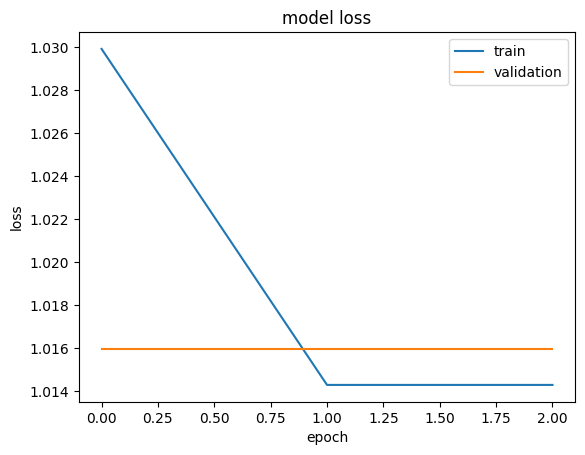

In [39]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Classification

In [40]:
encoder_model = Model(inputs=autoencoder3.input, outputs=autoencoder3.get_layer(index=4).output)

In [42]:
X_train_encoded = encoder_model.predict(X_train)
X_val_encoded = encoder_model.predict(X_val)
X_test_encoded = encoder_model.predict(X_test)

42/42 [==============================] - 0s 7ms/step


In [43]:

classifier = Sequential([
    Dense(3, activation="softmax")  #output layer (3 classes)
])

#compiling the classifier
classifier.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy')


In [44]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history=classifier.fit(X_train_encoded, y_train, epochs=200, batch_size=128, validation_data=(X_val_encoded, y_val), shuffle = True,callbacks=[early_stopping])


Epoch 1/200
32/32 [==============================] - 0s 6ms/step - loss: 2.3707 - val_loss: 1.4018
Epoch 2/200
32/32 [==============================] - 0s 3ms/step - loss: 1.2039 - val_loss: 1.2312
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 1.1033 - val_loss: 1.0574
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0556 - val_loss: 1.5763
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 1.2033 - val_loss: 1.0410
Epoch 6/200
32/32 [==============================] - 0s 4ms/step - loss: 1.0851 - val_loss: 1.1960
Epoch 7/200
32/32 [==============================] - 0s 3ms/step - loss: 1.2070 - val_loss: 1.0067
Epoch 8/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0688 - val_loss: 1.0233
Epoch 9/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0226 - val_loss: 1.0359


# Plot

dict_keys(['loss', 'val_loss'])


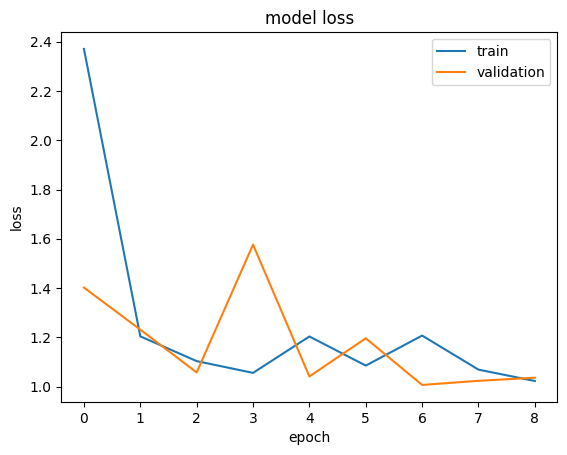

In [45]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Test

In [47]:
from sklearn.metrics import classification_report


y_pred_prob = classifier.predict(X_test_encoded)

#converting to class labels
y_pred = y_pred_prob.argmax(axis=1)  #getting class with highest probability

print(classification_report(y_test, y_pred, digits=4))

42/42 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       328
           1     0.5176    0.8775    0.6511       604
           2     0.5351    0.4082    0.4631       392

    accuracy                         0.5211      1324
   macro avg     0.3509    0.4285    0.3714      1324
weighted avg     0.3945    0.5211    0.4341      1324



In [ ]:
#############################################################################################################################################################################################

# SMOTE with Simple Autoencoder
you need to run the import cell and the first cell at the beginning then run the cell below for preprocessing 


In [53]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np


print("Original class distribution:", Counter(y_train))

#apply only on minority which is class 0
smote = SMOTE(sampling_strategy='minority', random_state=42) 
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# class distribution after SMOTE
print("Resampled class distribution:", Counter(y_train_resampled))



scaler = StandardScaler()
scaler.fit(X_train_resampled)

X_train_resampled = scaler.transform(X_train_resampled)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


Original class distribution: Counter({1: 1866, 2: 1111, 0: 995})
Resampled class distribution: Counter({0: 1866, 1: 1866, 2: 1111})


In [54]:
input_size = 70
hidden_size = 1000
bottleneck_size = 1000 
output_size = 70

In [55]:

input_layer = Input(shape=(input_size,))

encoder = Dense(hidden_size, activation="relu")(input_layer)


bottleneck = Dense(bottleneck_size, activation="relu")(encoder) 


decoder = Dense(hidden_size, activation="relu")(bottleneck)

output_layer = Dense(input_size, activation="sigmoid")(decoder)  

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

In [56]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder.fit(X_train_resampled, X_train_resampled, epochs=200, batch_size=128, validation_data=(X_val, X_val),shuffle=True, callbacks=[early_stopping])

Epoch 1/200
38/38 [==============================] - 1s 25ms/step - loss: 0.7384 - val_loss: 0.6827
Epoch 2/200
38/38 [==============================] - 1s 20ms/step - loss: 0.6234 - val_loss: 0.6283
Epoch 3/200
38/38 [==============================] - 1s 20ms/step - loss: 0.5959 - val_loss: 0.6170
Epoch 4/200
38/38 [==============================] - 1s 21ms/step - loss: 0.5897 - val_loss: 0.6127
Epoch 5/200
38/38 [==============================] - 1s 23ms/step - loss: 0.5866 - val_loss: 0.6099
Epoch 6/200
38/38 [==============================] - 1s 20ms/step - loss: 0.5847 - val_loss: 0.6085
Epoch 7/200
38/38 [==============================] - 1s 20ms/step - loss: 0.5835 - val_loss: 0.6073
Epoch 8/200
38/38 [==============================] - 1s 23ms/step - loss: 0.5829 - val_loss: 0.6066
Epoch 9/200
38/38 [==============================] - 1s 23ms/step - loss: 0.5823 - val_loss: 0.6062
Epoch 10/200
38/38 [==============================] - 1s 28ms/step - loss: 0.5819 - val_loss: 0.6061

# Plot

dict_keys(['loss', 'val_loss'])


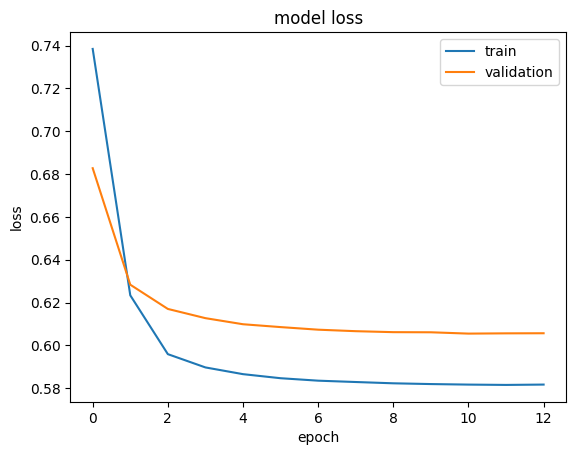

In [57]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

# Classification with softmax

In [59]:
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=2).output)

In [60]:
X_train_encoded = encoder_model.predict(X_train_resampled)
X_val_encoded = encoder_model.predict(X_val)
X_test_encoded = encoder_model.predict(X_test) 

42/42 [==============================] - 0s 4ms/step


In [61]:

classifier = Sequential([
    Dense(3, activation="softmax") 
])

classifier.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
classifier.fit(X_train_encoded, y_train_resampled, epochs=200, batch_size=128, validation_data=(X_val_encoded, y_val),shuffle=True, callbacks=[early_stopping])

Epoch 1/200
38/38 [==============================] - 0s 6ms/step - loss: 1.1085 - val_loss: 1.0557
Epoch 2/200
38/38 [==============================] - 0s 3ms/step - loss: 0.9725 - val_loss: 1.0108
Epoch 3/200
38/38 [==============================] - 0s 3ms/step - loss: 0.9478 - val_loss: 1.0058
Epoch 4/200
38/38 [==============================] - 0s 3ms/step - loss: 0.9437 - val_loss: 0.9816
Epoch 5/200
38/38 [==============================] - 0s 3ms/step - loss: 0.9385 - val_loss: 0.9701
Epoch 6/200
38/38 [==============================] - 0s 4ms/step - loss: 0.9380 - val_loss: 0.9955
Epoch 7/200
38/38 [==============================] - 0s 4ms/step - loss: 0.9323 - val_loss: 0.9826


dict_keys(['loss', 'val_loss'])


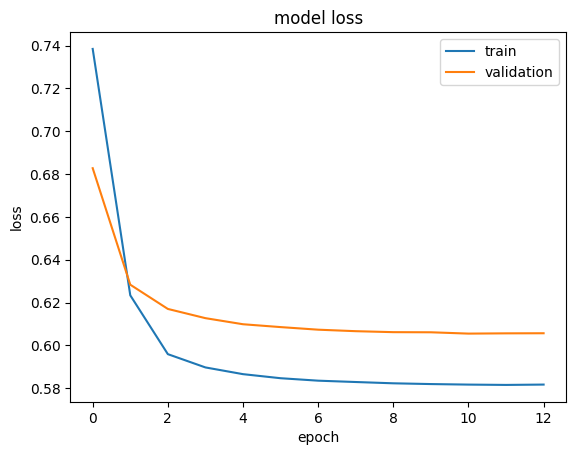

In [62]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [64]:
from sklearn.metrics import classification_report


y_pred_prob = classifier.predict(X_test_encoded)

#converting to class labels
y_pred = y_pred_prob.argmax(axis=1)  #getting class with highest probability

print(classification_report(y_test, y_pred, digits=4))

42/42 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.3117    0.3811    0.3429       328
           1     0.6552    0.6606    0.6579       604
           2     0.5828    0.4668    0.5184       392

    accuracy                         0.5340      1324
   macro avg     0.5166    0.5028    0.5064      1324
weighted avg     0.5487    0.5340    0.5386      1324

